In [266]:
import os
import h5py
import torch
import numpy as np
from importlib import reload

import main_sw
reload(main_sw)
from main_sw import main

## Processing

In [267]:
def extract_data(filepath: str) -> dict:
    """
    For a .h5 file specified by a filepath, this function returns
    data in the form of a dictionary.
    """

    results = {}
    with h5py.File(filepath, "r") as f:
        for key in f.keys():
            if type(f[key]) == h5py.Dataset:
                ds_arr = f[key][()]  # returns as a numpy array
                results[key] = ds_arr

            elif type(f[key]) == h5py.Group:
                group = f.get(key)
                gdict = {}
                for gkey in group.keys():
                    ds_arr = group[gkey][()]
                    gdict[gkey] = ds_arr
                results[key] = gdict

    return results

In [268]:
# Load raw data
path = os.path.join("/home/ucaptp0/oasis-rt-surrogate/data/raw_data")

files = [f for f in os.listdir(path) if "oasis_output_Venus_" in f]

outputs = {}
# Loads all output files and saves them within some object
for f in files: 
    timestep = int(f.split("Venus_")[1].split(".h5")[0])
    output = extract_data(os.path.join(path, f))
    output["timestep"] = timestep
    outputs[timestep] = output

In [269]:
# For each timestep, get targets
tgt_labels = [
    "fnet_dn_sw_h",
    "fnet_up_sw_h",
    "fnet_dn_lw_h",
    "fnet_up_lw_h",
]
targets = {}
for timestep, output in outputs.items():
    targets[timestep] = {}
    for lbl in tgt_labels:
        targets[timestep][lbl] = output[lbl]

In [270]:
print("Target shape: ", targets[20]["fnet_dn_sw_h"].shape)
print("Target type: ", type(targets[20]["fnet_dn_sw_h"]))

Target shape:  (512100,)
Target type:  <class 'numpy.ndarray'>


In [271]:
pressure = np.copy(outputs[20]["Pressure"])
temperature = np.copy(outputs[20]["Temperature"])
rho = np.copy(outputs[20]["Rho"])
sTemperature = np.copy(outputs[20]["sTemperature"])
cosz = np.copy(outputs[20]["cosz"])
alb_surf_sw = np.copy(outputs[20]["alb_surf_sw"])
alb_surf_lw = np.copy(outputs[20]["alb_surf_lw"])

In [272]:
ncol, nlay = 10242, 49
nlev = nlay + 1

pressure = np.reshape(pressure, newshape=(ncol, nlay))
temperature = np.reshape(temperature, newshape=(ncol, nlay))
rho = np.reshape(rho, newshape=(ncol, nlay))
sTemperature = np.reshape(sTemperature, newshape=(ncol,))
cosz = np.reshape(cosz, newshape=(ncol,))
alb_surf_sw = np.reshape(alb_surf_sw, newshape=(ncol,))
alb_surf_lw = np.reshape(alb_surf_lw, newshape=(ncol,))

## Main

In [274]:
sw_postprocessed_predictions, lw_postprocessed_predictions = main(pressure, temperature, rho, sTemperature, cosz, alb_surf_sw, alb_surf_lw)

3/3 [==============================] - 1s 241ms/step


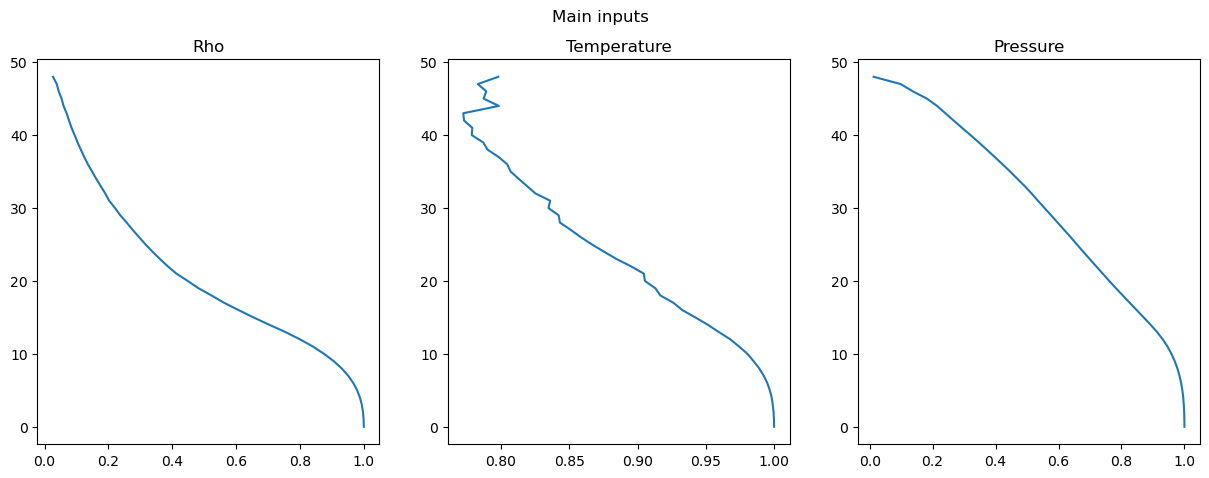

Aux inputs for col 0:  [0.88568061 0.15       0.19764676 0.45205937 0.84145833]


In [ ]:
# Plot inputs against altitude for a single column
import matplotlib.pyplot as plt

col = 0

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(inputs_main[col, :, 0], range(nlay), label="Rho")
axs[0].set_title("Rho")
axs[1].plot(inputs_main[col, :, 1], range(nlay), label="Temperature")
axs[1].set_title("Temperature")
axs[2].plot(inputs_main[col, :, 2], range(nlay), label="Pressure")
axs[2].set_title("Pressure")
plt.suptitle("Main inputs")
plt.show()

print(f"Aux inputs for col {col}: ", inputs_aux[col])

In [275]:
fnet_dn_sw_h = np.reshape(targets[20]['fnet_dn_sw_h'], newshape=(ncol, nlev))
fnet_up_sw_h = np.reshape(targets[20]['fnet_up_sw_h'], newshape=(ncol, nlev))
fnet_dn_lw_h = np.reshape(targets[20]['fnet_dn_lw_h'], newshape=(ncol, nlev))
fnet_up_lw_h = np.reshape(targets[20]['fnet_up_lw_h'], newshape=(ncol, nlev))

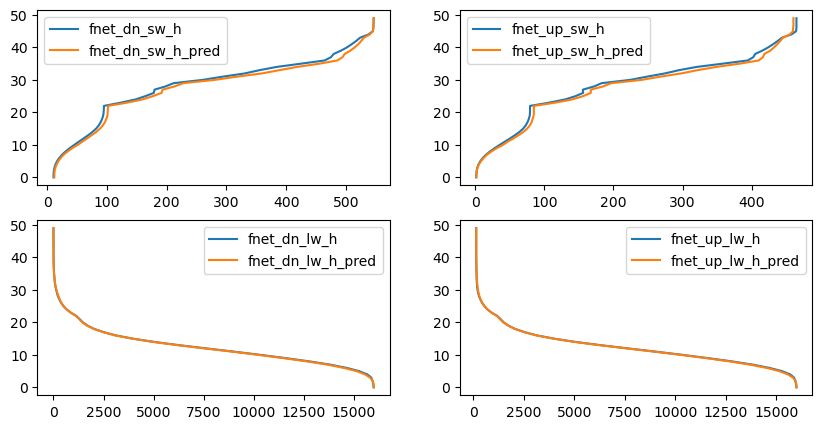

In [282]:
col = 999

# For col, plot two subplots of fnet_dn_sw_h and fnet_up_sw_h
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(10, 5))

ax[0, 0].plot(fnet_dn_sw_h[col, :], range(50), label="fnet_dn_sw_h")
ax[0, 0].plot(sw_postprocessed_predictions[col, :, 0], range(50), label="fnet_dn_sw_h_pred")
ax[0, 0].legend()

ax[0, 1].plot(fnet_up_sw_h[col, :], range(50), label="fnet_up_sw_h")
ax[0, 1].plot(sw_postprocessed_predictions[col, :, 1], range(50), label="fnet_up_sw_h_pred")
ax[0, 1].legend()

ax[1, 0].plot(fnet_dn_lw_h[col, :], range(50), label="fnet_dn_lw_h")
ax[1, 0].plot(lw_postprocessed_predictions[col, :, 0], range(50), label="fnet_dn_lw_h_pred")
ax[1, 0].legend()

ax[1, 1].plot(fnet_up_lw_h[col, :], range(50), label="fnet_up_lw_h")
ax[1, 1].plot(lw_postprocessed_predictions[col, :, 1], range(50), label="fnet_up_lw_h_pred")
ax[1, 1].legend()

plt.show()